In [38]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [78]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_out= dir_ssp_modeling.joinpath("ssp_run")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [41]:
dir_scenario_mapping

PosixPath('/home/tony-ubuntu/decision_sciences/ssp_mongolia/ssp_modeling/scenario_mapping')

In [42]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [43]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "mongolia_config.yaml")
config_params = g_utils.read_yaml(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']
set_lndu_reallocation_factor_to_zero_flag = config_params['set_lndu_reallocation_factor_to_zero']

# Print config parameters
print("Country name: ", country_name)
print("SSP input file name: ", ssp_input_file_name)
print("SSP transformation CW: ", ssp_transformation_cw)
print("Energy model flag: ", energy_model_flag)
print("Set lndu reallocation factor to zero flag: ", set_lndu_reallocation_factor_to_zero_flag)

Country name:  mongolia
SSP input file name:  MNG_real_data_20250604.csv
SSP transformation CW:  ssp_mongolia_transformation_v0.xlsx
Energy model flag:  False
Set lndu reallocation factor to zero flag:  True


In [44]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [45]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [46]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [47]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'ef_trns_mobile_combustion_water_borne_kg_n2o_per_tj_ammonia', 'exports_enfu_pj_fuel_ammonia', 'frac_trns_fuelmix_water_borne_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas', 'region', 'nemomod_entc_emissions_activity_ratio_scalar_fp_hydrogen_reformation_ccs_co2', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_water', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_ammonia', 'nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water', 'frac_enfu_fuel_demand_imported_pj_fuel_ammonia', 'energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_ammonia', 'nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia', 'nemomod_entc_input_activity_ratio_fue

In [48]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,Year,frac_lvst_mm_buffalo_composting,frac_lvst_mm_cattle_dairy_solid_storage,frac_lvst_mm_sheep_paddock_pasture_range,pij_lndu_forests_mangroves_to_settlements,frac_frst_mangroves_cl1_temperate_nutrient_rich,frac_agrc_tubers_cl1_tropical,yf_agrc_nuts_tonne_ha,frac_agrc_herbs_and_other_perennial_crops_cl2_dry,frac_lvst_mm_cattle_dairy_incineration,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,2015,0.0,0.21,0.8,0.0,0.5,0.0,0.620876,0.999038,0.11,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,2016,0.0,0.21,0.8,0.0,0.5,0.0,0.627214,0.999038,0.11,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,2017,0.0,0.21,0.8,0.0,0.5,0.0,0.601255,0.999038,0.11,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,2018,0.0,0.21,0.8,0.0,0.5,0.0,0.621593,0.999038,0.11,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,2019,0.0,0.21,0.8,0.0,0.5,0.0,0.622805,0.999038,0.11,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [49]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: set()
Columns in df_input but not in df_example: {'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_mwh', 'cost_enfu_fuel_coal_usd_per_m3', 'demscalar_ippu_recycled_plastic', 'demscalar_ippu_recycled_wood', 'demscalar_ippu_recycled_rubber_and_leather', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'cost_enfu_fuel_hydrogen_usd_per_tonne', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_mwh', 'cost_enfu_fuel_hydrocarbon_gas_liquids_usd_per_tonne', 'va_industrial_mmm_usd', 'va_commercial_mmm_usd', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_solar_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_waste_incineration_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_mwh', 'Year', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_mwh', 'demscalar_ippu_recycled_paper', 'demscalar_ippu_recycled_glass', 'nemomod_entc_variable_cost_pp_geothermal_m

In [50]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

['prodinit_ippu_lime_and_carbonite_tonne', 'consumpinit_inen_energy_tj_per_tonne_production_lime_and_carbonite', 'frac_enfu_fuel_demand_imported_pj_fuel_natural_gas']


In [51]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    costa_rica
1    costa_rica
2    costa_rica
3    costa_rica
4    costa_rica
Name: region, dtype: object

In [52]:
# Set region to country name
df_inputs_raw_complete['region'] = country_name
df_inputs_raw_complete['region'].head()

0    mongolia
1    mongolia
2    mongolia
3    mongolia
4    mongolia
Name: region, dtype: object

## Let's Modify the LNDU Reallocation factor

In [53]:
if set_lndu_reallocation_factor_to_zero_flag:
    df_inputs_raw_complete['lndu_reallocation_factor'] = 0.0

df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.0

#  Let's try building transformations using this


In [54]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [55]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


Directory /home/tony-ubuntu/decision_sciences/ssp_mongolia/ssp_modeling/transformations already exists. Skipping instantiation.


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [56]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/tony-ubuntu/decision_sciences/ssp_mongolia/ssp_modeling/scenario_mapping/ssp_mongolia_transformation_v0.xlsx


In [57]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

YAML file transformation_lsmm_inc_management_other.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_lvst_dec_enteric_fermentation.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_pflo_inc_ind_ccs.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_trns_shift_mode_regional.yaml already exist for strategy strategy_NZ. Please check it manually.
YAML file transformation_waso_inc_anaerobic_and_compost.yaml already exist for strategy strategy_NZ. Please check it manually.


In [58]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NZ': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NZ',
  'TX:AGRC:DEC_EXPORTS_STRATEGY_NZ',
  'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_NZ',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NZ',
  'TX:CCSQ:INC_CAPTURE_STRATEGY_NZ',
  'TX:ENTC:TARGET_CLEAN_HYDROGEN_STRATEGY_NZ',
  'TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_NZ',
  'TX:FGTV:DEC_LEAKS_STRATEGY_NZ',
  'TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_NZ',
  'TX:INEN:INC_EFFICIENCY_PRODUCTION_STRATEGY_NZ',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NZ',
  'TX:IPPU:DEC_HFCS_STRATEGY_NZ',
  'TX:IPPU:DEC_N2O_STRATEGY_NZ',
  'TX:IPPU:DEC_OTHER_FCS_STRATEGY_NZ',
  'TX:IPPU:DEC_PFCS_STRATEGY_NZ',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NZ',
  'TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_NZ',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NZ',
  'TX:LNDU:INC_SILVOPASTURE_STRATEGY_NZ',
  'TX:LSMM:INC_CAPTURE_BIOGAS_STRATEGY_NZ',
  'TX:LSMM:INC_MANAGEMENT_OTHER_STRATEGY_NZ',
  'TX:LVST:DEC_ENTERIC_FERMENTATION_STRATEGY_NZ',
  'TX:LVST:DEC_EXPORTS_STRATEGY_NZ',
  'TX:LVST:INC_PRODUCTIVIT

In [59]:
transformation_per_strategy_dict.keys()

dict_keys(['strategy_NZ'])

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [60]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

csv_handler.add_strategy(strategy_group='PFLO', description='Net Zero', yaml_file_suffix='NZ')

INFO: Strategy code PFLO:NZ already exists in the strategy definitions. Strategy will be updated...


Updated row with strategy_code PFLO:NZ


In [61]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003]

### We finished adding new transformation files and strategies so lets load them back

In [62]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [63]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/ssp_mongolia/ssp_modeling/transformations initialized in 3.9 seconds


In [64]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
65,4006,IP:ALL,Sectoral Composite - IPPU,All (unique by transformer) IPPU transformations,TX:IPPU:DEC_CLINKER|TX:IPPU:DEC_DEMAND|TX:IPPU...,0
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [65]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2260)
strat 6003 with output shape (36, 2260)
here = 6003


0

# Finally, load SISEPUEDE so that we can run it

In [66]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-06-12 10:50:55,360 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-12 10:50:55,360 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-06-12 10:50:55,363 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-12 10:50:55,363 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-06-12 10:50:55,364 - INFO - 	Setting export engine to 'csv'.
2025-06-12 10:50:55,364 - INFO - 	Setting export engine to 'csv'.
2025-06-12 10:50:55,365 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-06-12 10:50:55,365 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-06-12 10:50:55,367 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-06-12 10:50:55,367 - INFO - Successfully

In [67]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-06-12 10:51:27,212 - INFO - 
***	STARTING REGION mongolia	***

2025-06-12 10:51:27,212 - INFO - 
***	STARTING REGION mongolia	***

2025-06-12 10:51:30,917 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-12 10:51:30,917 - INFO - Trying run primary_id = 0 in region mongolia
2025-06-12 10:51:30,918 - INFO - Running AFOLU model
2025-06-12 10:51:30,918 - INFO - Running AFOLU model
2025-06-12 10:51:31,150 - INFO - AFOLU model run successfully completed
2025-06-12 10:51:31,150 - INFO - AFOLU model run successfully completed
2025-06-12 10:51:31,151 - INFO - Running CircularEconomy model
2025-06-12 10:51:31,151 - INFO - Running CircularEconomy model
2025-06-12 10:51:31,231 - INFO - CircularEconomy model run successfully completed
2025-06-12 10:51:31,231 - INFO - CircularEconomy model run successfully completed
2025-06-12 10:51:31,233 - INFO - Running IPPU model
2025-06-12 10:51:31,233 - INFO - Running IPPU model
2025-06-12 10:51:31,720 - INFO - IPPU model run successfully com

{'mongolia': [0, 69069]}

In [68]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Let's Explore the Results

In [69]:
def plot_field_stack(
    df,
    fields,
    dict_format,
    time_col="time_period",
    primary_id=0,
    figsize=(18, 8),
    legend_loc='upper right',
    legend_bbox=(1.1, 1),
    ylabel="MT Emissions CO2e",
    xlabel="Time Period",
    title=None,
):
    """
    Plots a stack plot of the selected fields for a given primary_id.

    Args:
        df (pd.DataFrame): DataFrame containing output data.
        fields (list): List of column names to plot.
        dict_format (dict): Formatting dictionary for colors.
        time_col (str): Name of the time column.
        primary_id (int): Value of primary_id to filter.
        figsize (tuple): Figure size.
        legend_loc (str): Legend location.
        legend_bbox (tuple): Legend bbox_to_anchor.
        ylabel (str): Y-axis label.
        xlabel (str): X-axis label.
        title (str): Plot title.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

    df_plot = df[df[ssp.key_primary].isin([primary_id])]

    fig, ax = spu.plot_stack(
        df_plot,
        fields,
        dict_formatting=dict_format,
        field_x=time_col,
        figtuple=(fig, ax),
    )

    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, title="Fields")
    plt.show()


In [70]:
# Define the fields to plot and the formatting dictionary
subsector_emission_fields = [
'emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil',
 'emission_co2e_subsector_total_waso',
 'emission_co2e_subsector_total_trww',
 'emission_co2e_subsector_total_ippu']

dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

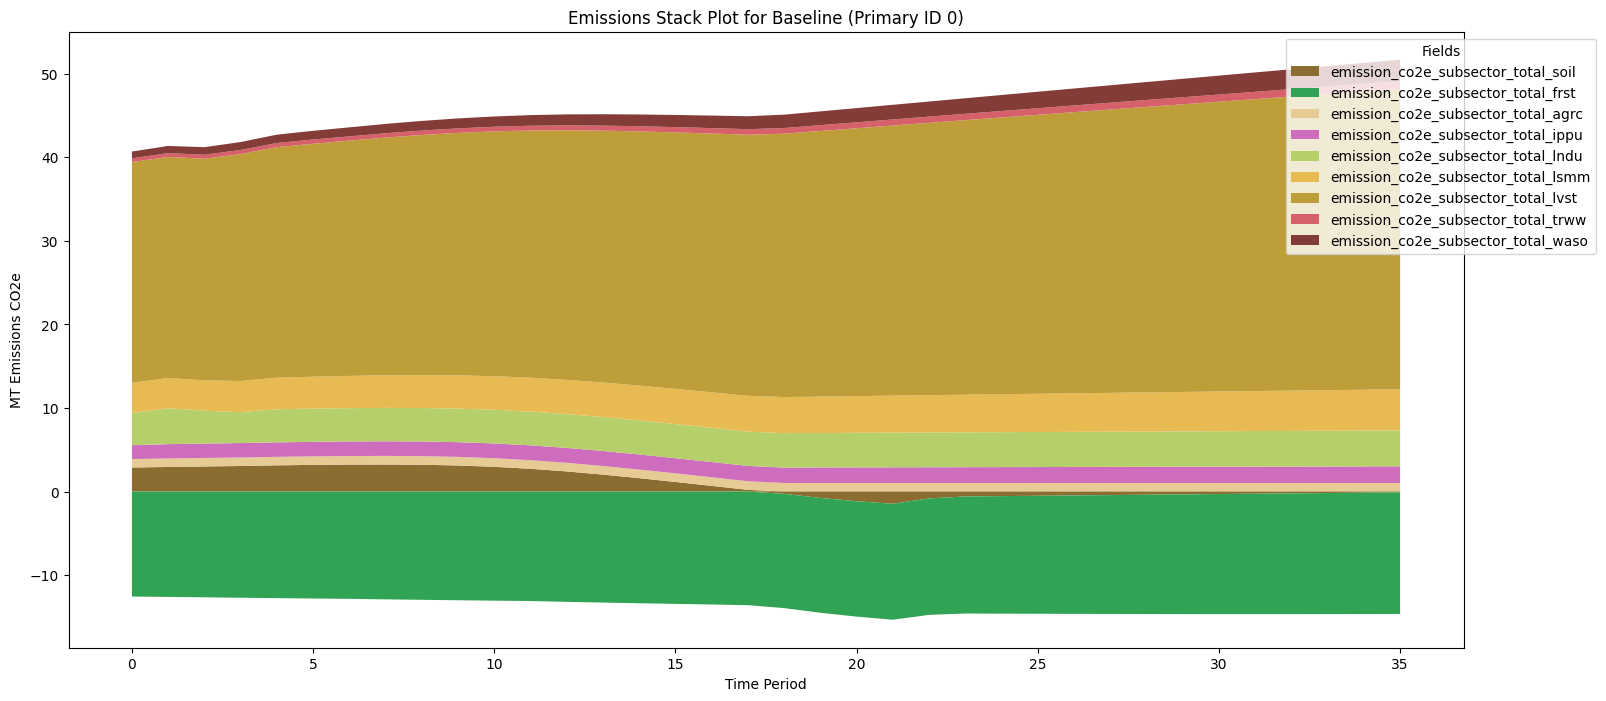

In [71]:
# Plot the emissions stack for the primary_id 0 (which is the baseline)
plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=0,
    title="Emissions Stack Plot for Baseline (Primary ID 0)"
)

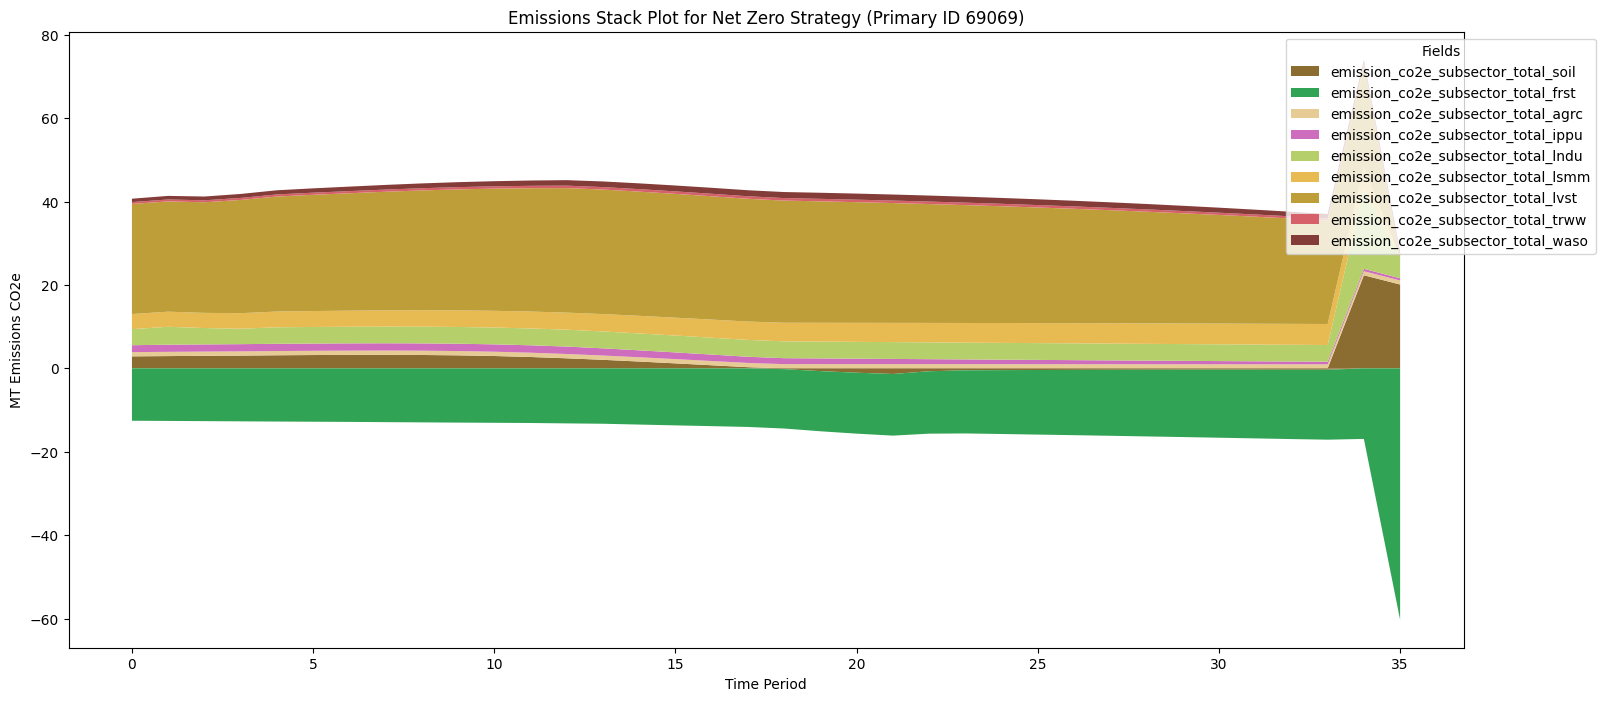

In [72]:
# Plot the emissions stack for the primary_id 69069 
plot_field_stack(
    df_out,
    subsector_emission_fields,
    dict_format,
    primary_id=69069,
    title="Emissions Stack Plot for Net Zero Strategy (Primary ID 69069)"
)

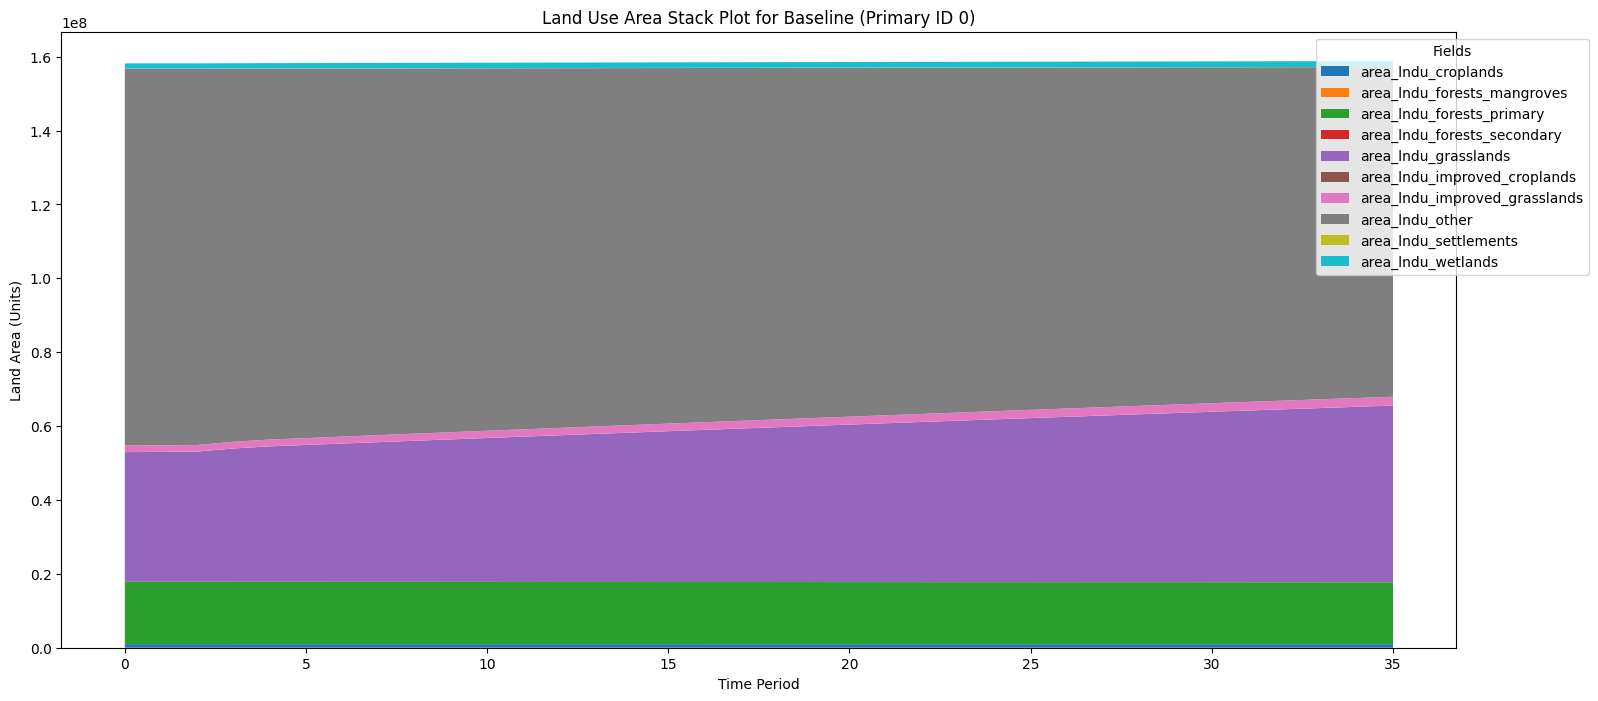

In [73]:
lndu_fields = [
    'area_lndu_croplands',
    'area_lndu_forests_mangroves', 'area_lndu_forests_primary',
    'area_lndu_forests_secondary', 'area_lndu_grasslands',
    'area_lndu_improved_croplands', 'area_lndu_improved_grasslands',
    'area_lndu_other', 'area_lndu_settlements', 'area_lndu_wetlands'
]

# Plot the land use area stack for the primary_id 0 (which is the baseline)
plot_field_stack(
    df_out,
    lndu_fields,
    dict_format,
    primary_id=0,
    title="Land Use Area Stack Plot for Baseline (Primary ID 0)",
    ylabel="Land Area (Units)",
    xlabel="Time Period",
)

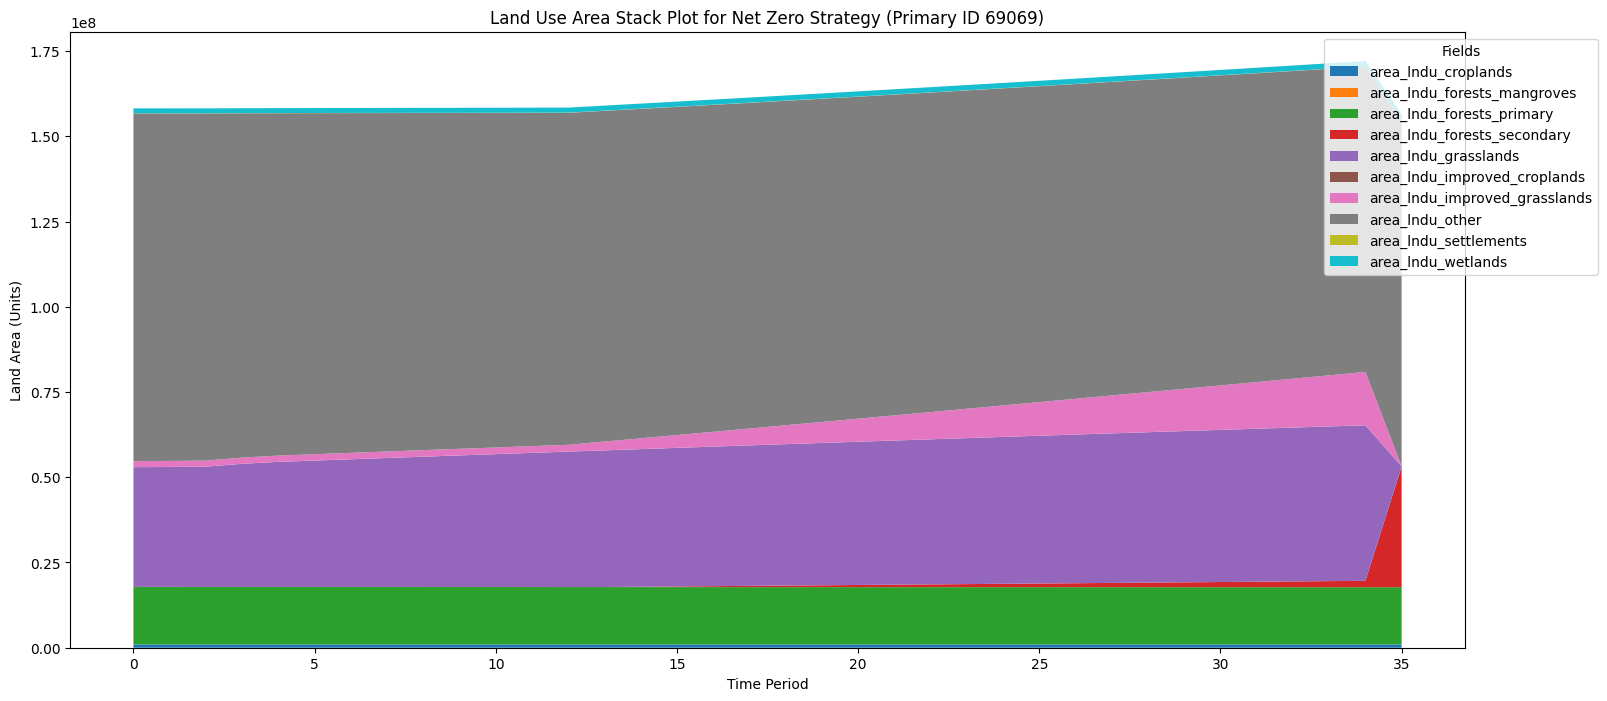

In [74]:
# Plot the land use area stack for the primary_id 69069
plot_field_stack(
    df_out,
    lndu_fields,
    dict_format,
    primary_id=69069,
    title="Land Use Area Stack Plot for Net Zero Strategy (Primary ID 69069)",
    ylabel="Land Area (Units)",
    xlabel="Time Period",
)

# Export Wide File (Last Mandatory Step)

In [75]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [76]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp_uganda/lib/python3.11/site-packages/sisepuede/out'

In [79]:
df_primary.to_csv(
    os.path.join(dir_out, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_out, f"sisepuede_results_sisepuede_mongolia_run.csv"),
    index = None,
    encoding = "UTF-8"
)

for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_out, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")